# **Environments and Functions**

It will take a few minutes for:

1. Download codes and pre-trained weights
2. Install Packages
3. Define common functions
4. Init the model

(Try to use gpu to speed up inference.)

In [ ]:
# download codes and pre-trained weights

import os
!git clone https://github.com/hustvl/ViTMatte.git
os.chdir('/content/ViTMatte')

!pip install gdown
import gdown
url='https://drive.google.com/u/0/uc?id=12VKhSwE_miF9lWQQCgK7mv83rJIls3Xe'
file_name='ViTMatte_S_Com.pth'
gdown.download(url, file_name)

Cloning into 'ViTMatte'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 120 (delta 40), reused 106 (delta 26), pack-reused 0
Receiving objects: 100% (120/120), 3.95 MiB | 34.60 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/u/0/uc?id=12VKhSwE_miF9lWQQCgK7mv83rJIls3Xe
To: /content/ViTMatte/ViTMatte_S_Com.pth
100%|██████████| 103M/103M [00:03<00:00, 28.4MB/s] 


'ViTMatte_S_Com.pth'

In [ ]:
# install packages

!pip install fairscale timm
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332112 sha256=c4b5f39784a59015de59fd7a20f01bd9e5f27fb035ca747079dc03efcf4a1356
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898f76e58ec421b88e8cb3
Successfully built fairscale
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning 

In [ ]:
# common functions

import os
from PIL import Image
from os.path import join as opj
from torchvision.transforms import functional as F
from detectron2.engine import default_argument_parser
from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer

def infer_one_image(model, input, save_dir=None):
    """
    Infer the alpha matte of one image.
    Input:
        model: the trained model
        image: the input image
        trimap: the input trimap
    """
    output = model(input)['phas'].flatten(0, 2)
    output = F.to_pil_image(output)
    output.save(opj(save_dir))

    return None

def init_model(model, checkpoint, device):
    """
    Initialize the model.
    Input:
        config: the config file of the model
        checkpoint: the checkpoint of the model
    """
    assert model in ['vitmatte-s', 'vitmatte-b']
    if model == 'vitmatte-s':
        config = 'configs/common/model.py'
        cfg = LazyConfig.load(config)
        model = instantiate(cfg.model)
        model.to(device)
        model.eval()
        DetectionCheckpointer(model).load(checkpoint)
    elif model == 'vitmatte-b':
        config = 'configs/common/model.py'
        cfg = LazyConfig.load(config)
        cfg.model.backbone.embed_dim = 768
        cfg.model.backbone.num_heads = 12
        cfg.model.decoder.in_chans = 768
        model = instantiate(cfg.model)
        model.to(device)
        model.eval()
        DetectionCheckpointer(model).load(checkpoint)
    return model

def get_data(image_dir, trimap_dir):
    """
    Get the data of one image.
    Input:
        image_dir: the directory of the image
        trimap_dir: the directory of the trimap
    """
    image = Image.open(image_dir).convert('RGB')
    image = F.to_tensor(image).unsqueeze(0)
    trimap = Image.open(trimap_dir).convert('L')
    trimap = F.to_tensor(trimap).unsqueeze(0)

    return {
        'image': image,
        'trimap': trimap
    }

def cal_foreground(image_dir, alpha_dir):
    """
    Calculate the foreground of the image.
    Input:
        image_dir: the directory of the image
        alpha_dir: the directory of the alpha matte
    Output:
        foreground: the foreground of the image, numpy array
    """
    image = Image.open(image_dir).convert('RGB')
    alpha = Image.open(alpha_dir).convert('L')
    alpha = F.to_tensor(alpha).unsqueeze(0)
    image = F.to_tensor(image).unsqueeze(0)
    foreground = image * alpha + (1 - alpha)
    foreground = foreground.squeeze(0).permute(1, 2, 0).numpy()

    return foreground

def merge_new_bg(image_dir, bg_dir, alpha_dir):
    """
    Merge the alpha matte with a new background.
    Input:
        image_dir: the directory of the image
        bg_dir: the directory of the new background
        alpha_dir: the directory of the alpha matte
    """
    image = Image.open(image_dir).convert('RGB')
    bg = Image.open(bg_dir).convert('RGB')
    alpha = Image.open(alpha_dir).convert('L')
    image = F.to_tensor(image)
    bg = F.to_tensor(bg)
    bg = F.resize(bg, image.shape[-2:])
    alpha = F.to_tensor(alpha)
    new_image = image * alpha + bg * (1 - alpha)

    new_image = new_image.squeeze(0).permute(1, 2, 0).numpy()
    return new_image

In [ ]:
# init the model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = init_model(model='vitmatte-s', checkpoint='/content/ViTMatte/ViTMatte_S_Com.pth', device=device)

# **Results on Composition-1k**
1. Opaque Object
2. Transparent Object

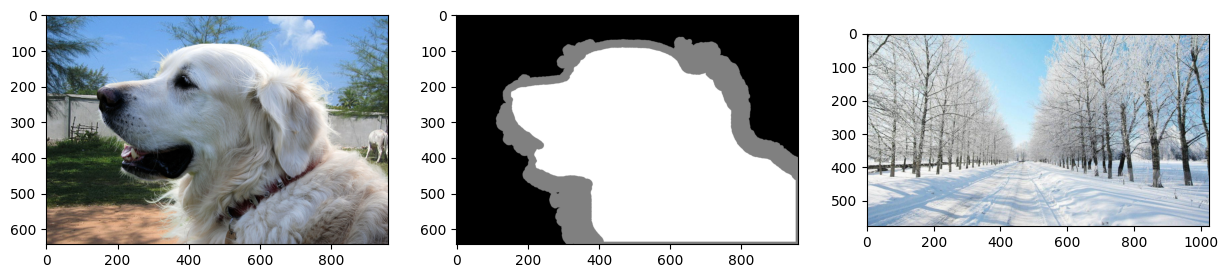

In [ ]:
# get opaque data
import matplotlib.pyplot as plt
import numpy as np

image_dir = '/content/ViTMatte/demo/retriever_rgb.png'
trimap_dir = '/content/ViTMatte/demo/retriever_trimap.png'
bg_dir = '/content/ViTMatte/demo/new_bg.jpg'

image = np.array(Image.open(image_dir))
trimap = np.array(Image.open(trimap_dir))
bg = np.array(Image.open(bg_dir))

input = get_data(image_dir, trimap_dir)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(trimap)
plt.subplot(1, 3, 3)
plt.imshow(bg)
plt.show()

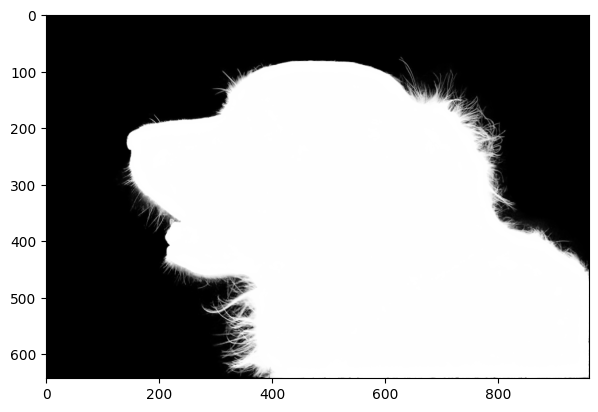

In [ ]:
# infer with model
save_dir = '/content/ViTMatte/demo/result.png'
alpha = infer_one_image(model, input, save_dir)

plt.figure(figsize=(7, 7))
plt.imshow(np.array(Image.open('demo/result.png')), cmap='gray')
plt.show()

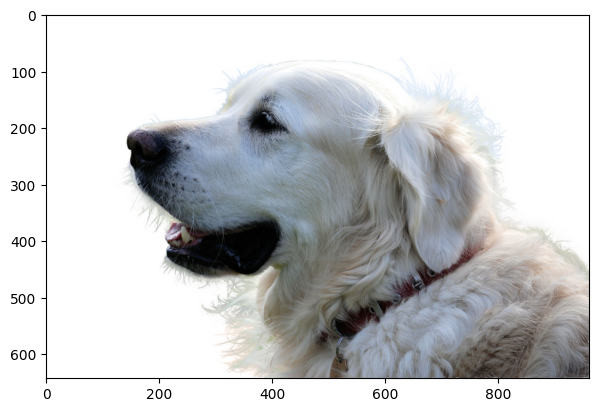

In [ ]:
# calculate foreground with the alpha matte prediction

fg = cal_foreground(image_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


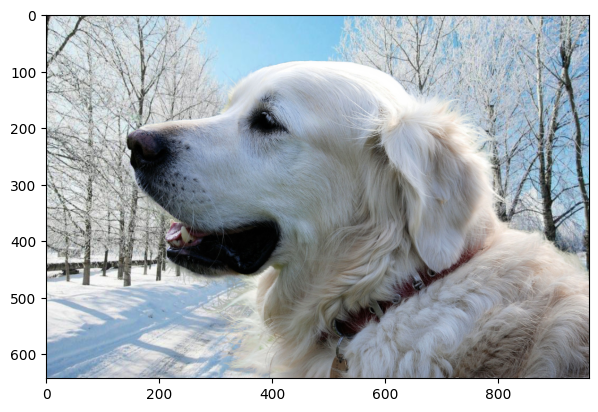

In [ ]:
# merge with new background

new_image = merge_new_bg(image_dir, bg_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(new_image)
plt.show()

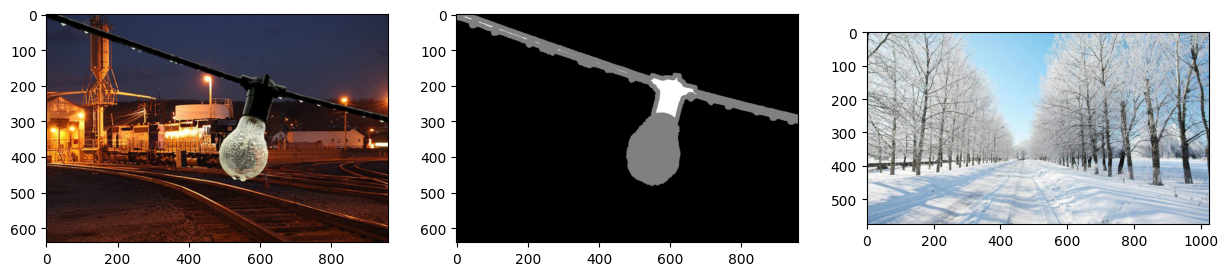

In [ ]:
# get transparent data

image_dir = '/content/ViTMatte/demo/bulb_rgb.png'
trimap_dir = '/content/ViTMatte/demo/bulb_trimap.png'

image = np.array(Image.open(image_dir))
trimap = np.array(Image.open(trimap_dir))
bg = np.array(Image.open(bg_dir))

input = get_data(image_dir, trimap_dir)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(trimap)
plt.subplot(1, 3, 3)
plt.imshow(bg)
plt.show()

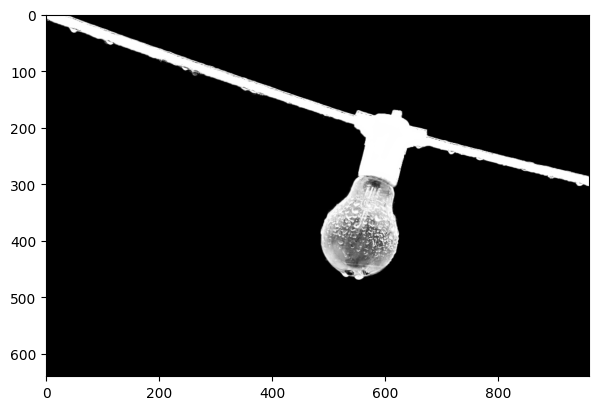

In [ ]:
# infer with model
save_dir = '/content/ViTMatte/demo/result.png'
alpha = infer_one_image(model, input, save_dir)

plt.figure(figsize=(7, 7))
plt.imshow(np.array(Image.open('demo/result.png')), cmap='gray')
plt.show()

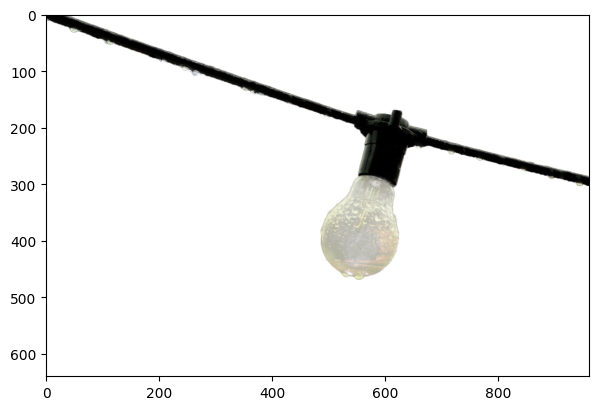

In [ ]:
# calculate foreground with the alpha matte prediction

fg = cal_foreground(image_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


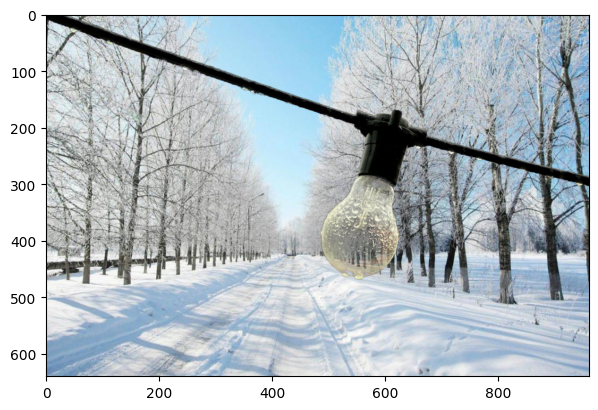

In [ ]:
# merge with new background

new_image = merge_new_bg(image_dir, bg_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(new_image)
plt.show()